### Product Recommentation - ResNet50

In this notebook we are going to implement the image recommendation algorithm using the `ResNet50` base model. Given an image of a product we want to find similar images of that product by calculating the `cosine similarity` score since it is independen  of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
<p align="center"><img alt="image" src="https://miro.medium.com/v2/resize:fit:1400/1*LfW66-WsYkFqWc4XYJbEJg.png" width="40%"/></p>



For the dataset we are going to use the one that was obtained from kaggle:

> Dataset: https://www.kaggle.com/datasets/fatihkgg/ecommerce-product-images-18k


First we are going to import all the packages that we are going to use in this notebook.

In [1]:
import torch
import random
import time
import os
import copy
import shutil
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd


from torch.nn import functional as F
from torchvision import transforms
from torch.utils import data
from torchvision import models
from sklearn import decomposition, manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from uuid import uuid4
from PIL import Image

print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

torch:  2.4.0
numpy:  1.26.4
pandas:  2.2.3


In the next code cell we are going to define the paths to our image.

In [2]:
IMAGES_PATH = "/kaggle/input/ecommerce-product-images-18k/"
DATABASE_IMAGES = "images"

In the following code cell we are going to move all the images in different split sets to a single `images` folder.

In [3]:
if os.path.exists(DATABASE_IMAGES):
    shutil.rmtree(DATABASE_IMAGES)

if not os.path.exists(DATABASE_IMAGES):
    os.makedirs(DATABASE_IMAGES)
    
print("Done!")

Done!


First we are going to start by moving the images in the `check` directory to the `images` directory.

In [4]:
for class_ in os.listdir(os.path.join(IMAGES_PATH, 'ECOMMERCE_PRODUCT_IMAGES/check')):
    class_folder = os.path.join(IMAGES_PATH, 'ECOMMERCE_PRODUCT_IMAGES/check', class_)
    for image in tqdm(os.listdir(class_folder)):
        new_name = f"{uuid4().hex}.{image.split('.')[-1]}"
        shutil.copy(os.path.join(class_folder, image), os.path.join(
            DATABASE_IMAGES, new_name
        ))

100%|██████████| 155/155 [00:00<00:00, 238.35it/s]


Then we are going to also move the images in the train set.

In [5]:
for class_ in os.listdir(os.path.join(IMAGES_PATH, 'ECOMMERCE_PRODUCT_IMAGES/train')):
    class_folder = os.path.join(IMAGES_PATH, 'ECOMMERCE_PRODUCT_IMAGES/train', class_)
    for image in tqdm(os.listdir(class_folder)):
        new_name = f"{uuid4().hex}.{image.split('.')[-1]}"
        shutil.copy(os.path.join(class_folder, image), os.path.join(
            DATABASE_IMAGES, new_name
        ))

100%|██████████| 3978/3978 [00:15<00:00, 250.75it/s]


Again we are also going to move the images in the validation directory.

In [6]:
for class_ in os.listdir(os.path.join(IMAGES_PATH, 'ECOMMERCE_PRODUCT_IMAGES/val')):
    class_folder = os.path.join(IMAGES_PATH, 'ECOMMERCE_PRODUCT_IMAGES/val', class_)
    for image in tqdm(os.listdir(class_folder)):
        new_name = f"{uuid4().hex}.{image.split('.')[-1]}"
        shutil.copy(os.path.join(class_folder, image), os.path.join(
            DATABASE_IMAGES, new_name
        ))

100%|██████████| 1033/1033 [00:03<00:00, 268.31it/s]


### Seed

We are going to set the seed for all random operations in the following code cell for reproducivity in this notebook.

In [7]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

We are going to check if we will have access to a `GPU` for speed mathemetical computations

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### ResNet50

In the following code cell we are going to download the pretrained model.

In [9]:
resnet50 = models.resnet50(weights = True).to(device)
resnet50

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet model output `1000` different classes. We are going to finetune the last layer of our model so that it output a vector of dimention `20` insteard of `1000`.

In [10]:
IN_FEATURES = resnet50.fc.in_features 
OUTPUT_DIM = 20
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
fc

Linear(in_features=2048, out_features=20, bias=True)

In the following code cell we are modifying the output layer of the `ResNet50` so that it output the vector dimension we desire.

In [11]:
resnet50.fc = fc

### Image Transformations

In the following code cell we are going to create some image tranformation object, which will tranform the image for inference/testing for the expectations of the `ResNet50`.

In [12]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
  transforms.Resize(pretrained_size),
  transforms.ToTensor(),
  transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
])

Next we are going to define a function that loads an image file to a tensor image.

In [13]:
def load_image(path):
    image = Image.open(path)
    return image_transforms(image)

In the next code cell we are going to create a function that will be responsible for generating vectors of all the images in the database. These vectors will be saved as a pandas dataframe with two columns which are:

1. `vector` - a vector represantation of the image after it has been passed through resnet50
2. `image` - a file name of that image, which correcpond to the vector.

In [14]:
def generete_vectors(model, device):
    model = model.to(device)
    model.eval()
    data = []
    with torch.no_grad():
        for image_path in tqdm(os.listdir(DATABASE_IMAGES)):
            image = load_image(os.path.join(DATABASE_IMAGES, image_path)).to(device).unsqueeze(0)
            vector = model(image).cpu().squeeze().numpy()
            data.append({'vector': vector, 'image': image_path})
    return data
data = generete_vectors(resnet50, device)

100%|██████████| 18175/18175 [02:19<00:00, 130.05it/s]


In the next code cell we are going to check the generated dataframe.

In [15]:
df = pd.DataFrame(data)
df.head(2)

,vector,image
0,"[0.26794067, 0.4864945, -0.7081244, -0.0311021...",1915016aaefc4df68c9abd65adefbfc2.jpeg
1,"[0.09070244, 0.23441553, 0.007948808, -0.19005...",ffb1538b82c341f088130d718a85d457.jpeg


Next we are going to save our dataframe as a `csv` file so that we can load the vectors with their respective file name from a file rather than extracting vectors again using resnet.

In [16]:
df.to_csv("vectors.csv", index=False)
print("Done")

Done


Next we are going to load our `csv` file so that we can load our vectors with their respective image file name from a `csv` file.

In [17]:
dataframe = pd.read_csv('vectors.csv')
dataframe.head(2)

,vector,image
0,[ 0.26794067 0.4864945 -0.7081244 -0.031102...,1915016aaefc4df68c9abd65adefbfc2.jpeg
1,[ 0.09070244 0.23441553 0.00794881 -0.190050...,ffb1538b82c341f088130d718a85d457.jpeg


After loading our data from the `vectors.csv` we are going to convert the column values of `vectors` into numpy arrays from strings.

In [18]:
dataframe.vector = dataframe.vector.apply(
    lambda x:  
          np.fromstring(
              x.replace('\n','')
            .replace('[','')
            .replace(']','')
            .replace('  ',' '), 
            sep=' ')
)

Then we are going to create a matrix of dimension `(n_images, 20)`.

In [19]:
matrix = []
for v in dataframe.vector.values:
    matrix.append(list(v))
matrix = np.array(matrix).astype(np.float32)
matrix.shape

(18175, 20)

In the following code cell we are then going to calculate the cosine simmilarity between different images and we will save them in the `algorithm` variable.

In [20]:
algorithm = cosine_similarity(matrix, matrix) 

Let's get all the image file names that we have in the database so that we will randomly predict recommendations base on the images.

In [21]:
images = dataframe.image.values

The `get_suggestion` function takes in the image file name, and the algorithm and return `10` results that are simmilar to that image.

In [22]:
def get_suggestions(image, algorithm, n=10):
    indices = pd.Series(dataframe.index, index=dataframe['image']).drop_duplicates()
    try:
        idx = indices[image]
        # Get the pairwsie similarity scores of all images with that image
        sim_scores = list(enumerate(algorithm[idx]))
        # Sort the images based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores of the n most similar images
        sim_scores = sim_scores[0:11]
        # Get the movie images
        images_indices = [i[0] for i in sim_scores]
        filenames = list(dataframe['image'].iloc[images_indices].values)
        probability = [i[1] for i in sim_scores]
        return list(zip(filenames, probability))
    except KeyError:
        print(f"Image with file name '{image}' does not exist.")

suggestions = get_suggestions(random.choice(images), algorithm)

In the following code cell we are going to create a `plot_suggestions` function which will plot the image and the predictions or recommentations based on the predicted suggestions.

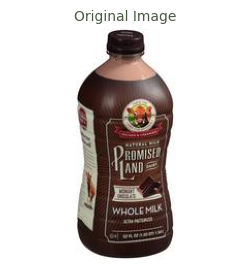

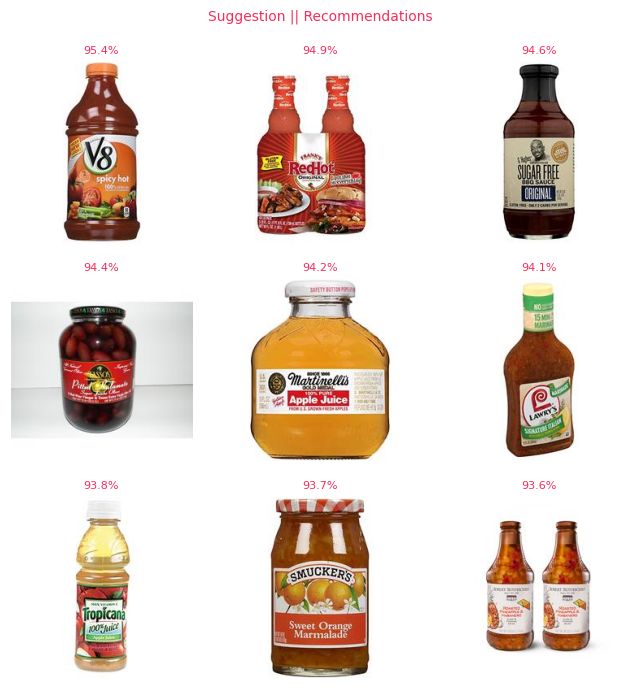

In [23]:
def plot_suggestions(suggestions):
    plt.figure(figsize=(3, 3))
    plt.imshow(Image.open(os.path.join(DATABASE_IMAGES, suggestions[0][0])))
    plt.title("Original Image", fontsize=10, color="#4B5945")
    plt.axis('off')
    plt.show()
    
    suggestions = suggestions[1:]
    n_images = len(suggestions[1:])
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (8, 8))
    plt.title("Suggestion || Recommendations\n\n", fontsize=10, color="#F72C5B")
    plt.axis('off')
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = Image.open(os.path.join(DATABASE_IMAGES, suggestions[i][0]))
        ax.imshow(image)
        ax.set_title(f"{suggestions[i][1] * 100:.1f}%", fontsize=8, color="#F72C5B")
        ax.axis('off')
plot_suggestions(suggestions)

Let's make another random prediction...

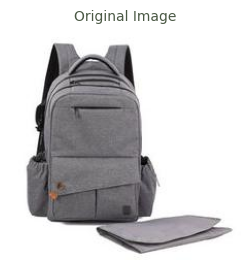

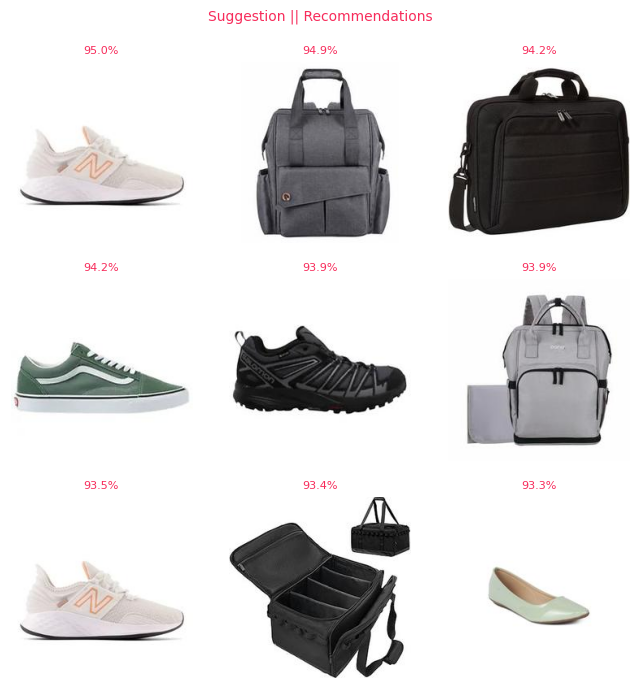

In [24]:
plot_suggestions(
    get_suggestions(random.choice(images), algorithm)
)

Let's make another random prediction...

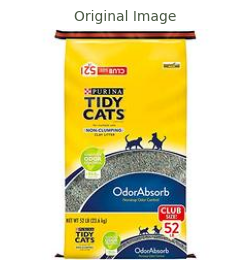

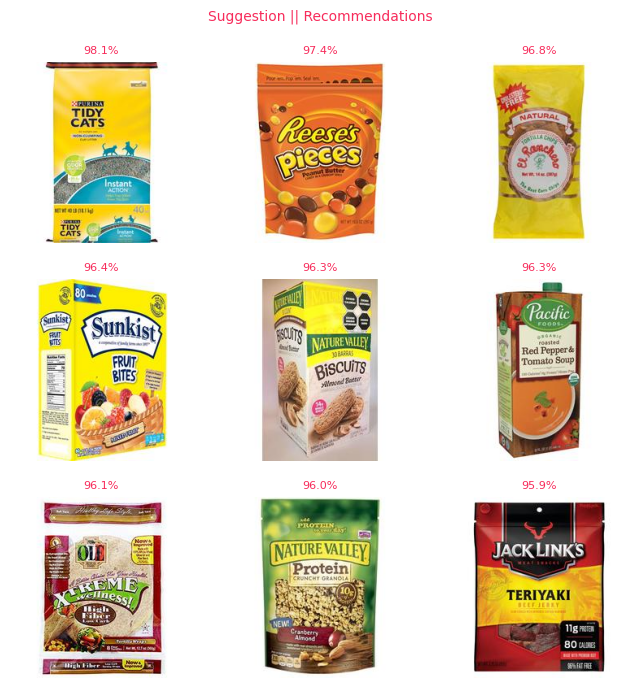

In [25]:
plot_suggestions(
    get_suggestions(random.choice(images), algorithm)
)